[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NU-MSE-LECTURES/465_Computational_Microscopy_2026/blob/dev/Week_04/code_examples/example_02_unsupervised_learning.ipynb)

# Example 02: Unsupervised Learning for Electron Microscopy

## Overview
This notebook demonstrates unsupervised learning techniques for analyzing unlabeled microscopy data:
1. **Clustering (k-Means & DBSCAN)** - Group similar particles/regions without labels
2. **Dimensionality Reduction (PCA & t-SNE)** - Visualize high-dimensional feature spaces
3. **Anomaly Detection** - Identify defects, contaminants, or unusual structures
4. **Non-negative Matrix Factorization (NMF)** - Decompose spectral/compositional data

## Learning Objectives
- Understand when and why to use unsupervised learning in microscopy
- Apply clustering algorithms to segment materials phases without labels
- Use dimensionality reduction for data exploration and visualization
- Detect anomalies and rare events in large datasets
- Evaluate unsupervised models using intrinsic metrics (silhouette score, inertia)

In [1]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install -q hyperspy scikit-learn scikit-image scipy matplotlib seaborn pandas umap-learn
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    import os
    os.chdir('465_Computational_Microscopy_2026/Week_04/code_examples')
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [18]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Image processing
from skimage import filters, morphology, measure, feature, segmentation, data
from scipy import ndimage

# Machine Learning - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Dimensionality Reduction
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.manifold import TSNE

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

# Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Set random seed
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Part 1: Synthetic Multi-Phase Material Dataset

We generate a controllable STEM-HAADF-like image with three phases (bright FCC grains, medium HCP grains, dark BCC matrix). Having ground-truth labels lets us benchmark clustering quality later (e.g., compare cluster maps to the true phase map). Noise and blurring are added to mimic real data while keeping the physics plausible.

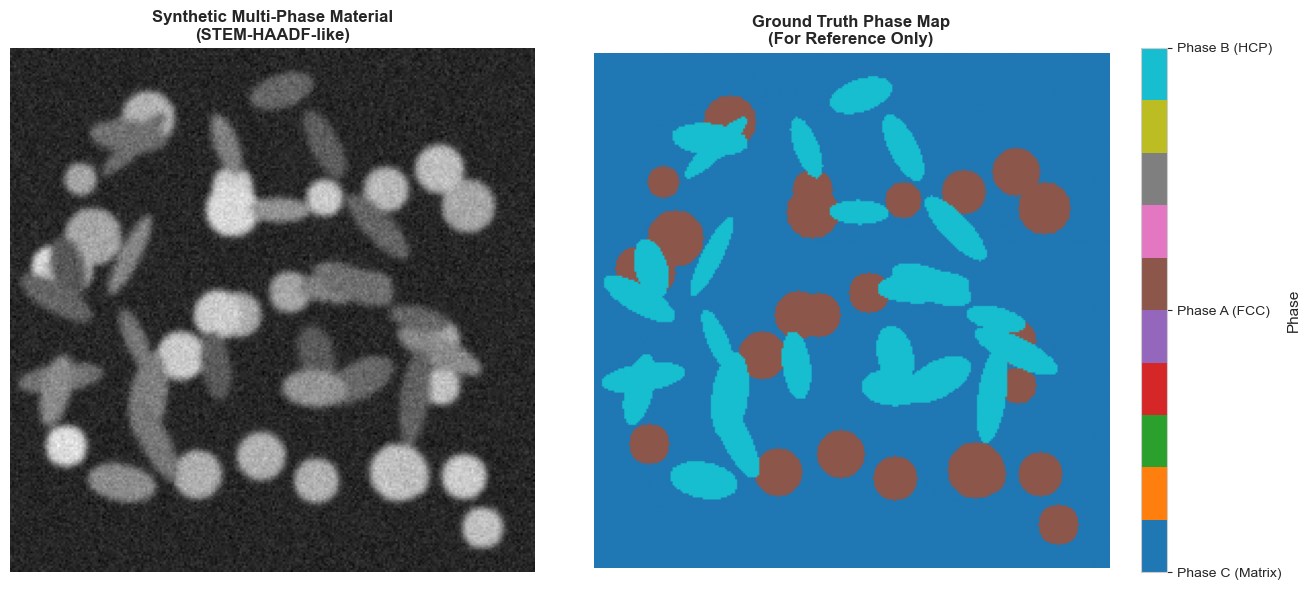

Image size: (256, 256)
Intensity range: [0.178, 0.986]
Phase distribution: [48179  7888  9469]


In [19]:
def create_multiphase_material(img_size=256, n_grains=40):
    """
    Generate synthetic multi-phase material with three phases:
    - Phase A: Bright circular grains (e.g., FCC phase)
    - Phase B: Medium intensity elongated grains (e.g., HCP phase)
    - Phase C: Dark background matrix (e.g., BCC phase)
    
    Returns:
        image: Synthetic STEM-HAADF-like image
        phase_map: Ground truth phase labels (for validation only)
    """
    image = np.ones((img_size, img_size)) * 0.3  # Background (Phase C)
    phase_map = np.zeros((img_size, img_size), dtype=int)  # 0 = Phase C
    
    # Generate Phase A grains (bright, circular)
    n_phase_a = n_grains // 2
    for _ in range(n_phase_a):
        x = np.random.randint(20, img_size - 20)
        y = np.random.randint(20, img_size - 20)
        radius = np.random.randint(8, 15)
        intensity = np.random.uniform(0.7, 0.9)
        
        Y, X = np.ogrid[:img_size, :img_size]
        mask = (X - x)**2 + (Y - y)**2 <= radius**2
        
        image[mask] = intensity
        phase_map[mask] = 1  # Phase A
    
    # Generate Phase B grains (medium, elongated)
    n_phase_b = n_grains // 2
    for _ in range(n_phase_b):
        x = np.random.randint(20, img_size - 20)
        y = np.random.randint(20, img_size - 20)
        length = np.random.randint(15, 25)
        width = np.random.randint(5, 10)
        angle = np.random.uniform(0, 2 * np.pi)
        intensity = np.random.uniform(0.45, 0.65)
        
        from skimage.draw import ellipse
        rr, cc = ellipse(y, x, width, length, rotation=angle)
        valid = (rr >= 0) & (rr < img_size) & (cc >= 0) & (cc < img_size)
        
        image[rr[valid], cc[valid]] = intensity
        phase_map[rr[valid], cc[valid]] = 2  # Phase B
    
    # Apply realistic smoothing and noise
    image = filters.gaussian(image, sigma=1.5)
    noise = np.random.normal(0, 0.03, image.shape)
    image = np.clip(image + noise, 0, 1)
    
    return image, phase_map

# Generate dataset
image, true_phase_map = create_multiphase_material(img_size=256, n_grains=50)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Synthetic Multi-Phase Material\n(STEM-HAADF-like)', fontsize=12, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(true_phase_map, cmap='tab10')
axes[1].set_title('Ground Truth Phase Map\n(For Reference Only)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], ticks=[0, 1, 2])
cbar.set_label('Phase', fontsize=11)
cbar.ax.set_yticklabels(['Phase C (Matrix)', 'Phase A (FCC)', 'Phase B (HCP)'])

plt.tight_layout()
plt.show()

print(f"Image size: {image.shape}")
print(f"Intensity range: [{image.min():.3f}, {image.max():.3f}]")
print(f"Phase distribution: {np.bincount(true_phase_map.ravel())}")

---
## Part 2: Feature Extraction (Pixel-Based)

Unsupervised methods rely on good descriptors. We compute per-pixel intensity plus local statistics (mean, std), edge strength (gradient), and curvature (Laplacian) over a small window. This captures brightness, texture, and boundaries so phases separate cleanly in feature space. Features are standardized so distance-based methods (k-Means, DBSCAN) treat each channel equally.

In [5]:
def extract_pixel_features(image, window_size=5):
    """
    Extract local features for each pixel:
    - Intensity value
    - Local mean (neighborhood average)
    - Local std (texture measure)
    - Gradient magnitude (edge information)
    - Laplacian (second derivative, detects edges)
    
    Returns:
        features: Array of shape (n_pixels, n_features)
        coordinates: (row, col) positions of each pixel
    """
    h, w = image.shape
    
    # Feature maps
    intensity = image.copy()
    local_mean = ndimage.uniform_filter(image, size=window_size)
    local_std = ndimage.generic_filter(image, np.std, size=window_size)
    
    # Gradient magnitude
    gradient_y, gradient_x = np.gradient(image)
    gradient_mag = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Laplacian (edge detector)
    laplacian = ndimage.laplace(image)
    
    # Stack all features
    feature_stack = np.stack([
        intensity,
        local_mean,
        local_std,
        gradient_mag,
        laplacian
    ], axis=-1)
    
    # Reshape to (n_pixels, n_features)
    features = feature_stack.reshape(-1, 5)
    
    # Get pixel coordinates
    rows, cols = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    coordinates = np.column_stack([rows.ravel(), cols.ravel()])
    
    return features, coordinates

# Extract features
print("Extracting pixel-level features...")
features, coords = extract_pixel_features(image, window_size=7)
print(f"Feature matrix shape: {features.shape}")
print(f"Features per pixel: {features.shape[1]}")

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("\nFeatures standardized (zero mean, unit variance).")

Extracting pixel-level features...
Feature matrix shape: (65536, 5)
Features per pixel: 5

Features standardized (zero mean, unit variance).


---
## Part 3: k-Means Clustering

k-Means partitions pixels into k groups by minimizing within-cluster variance. We scan k=2–7, using inertia (elbow) and silhouette to pick k=3, matching the three known phases. Outputs: cluster map, intrinsic metrics (silhouette high, Davies-Bouldin low, Calinski-Harabasz high) to judge separation even without labels.

Testing different numbers of clusters...
k=2: Inertia=195896, Silhouette=0.468
k=3: Inertia=143967, Silhouette=0.485
k=4: Inertia=112786, Silhouette=0.321
k=5: Inertia=98743, Silhouette=0.323
k=6: Inertia=88452, Silhouette=0.322
k=7: Inertia=80542, Silhouette=0.269


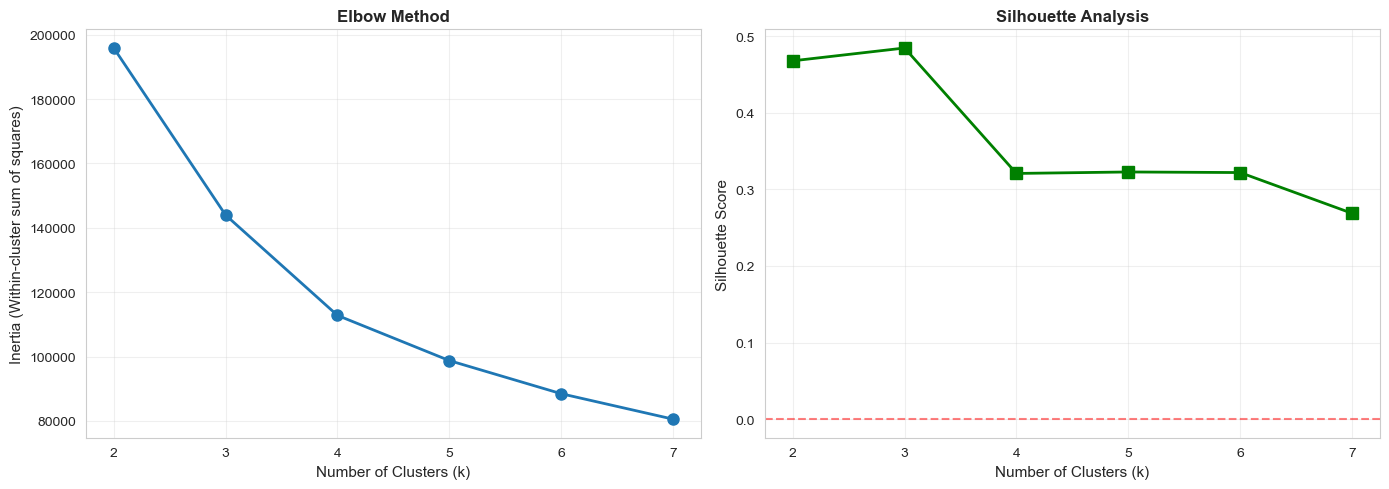


Selected k=3 based on elbow and silhouette score.


In [20]:
# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 8)

print("Testing different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, labels))
    print(f"k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 's-', color='green', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Choose k=3 based on domain knowledge (3 phases)
optimal_k = 3 
print(f"\nSelected k={optimal_k} based on elbow and silhouette score.")


k-Means Clustering Results (k=3):
  Silhouette Score: 0.485 (higher is better, range [-1, 1])
  Davies-Bouldin Index: 0.983 (lower is better)
  Calinski-Harabasz Score: 41812.6 (higher is better)

Cluster sizes: [10910 46679  7947]


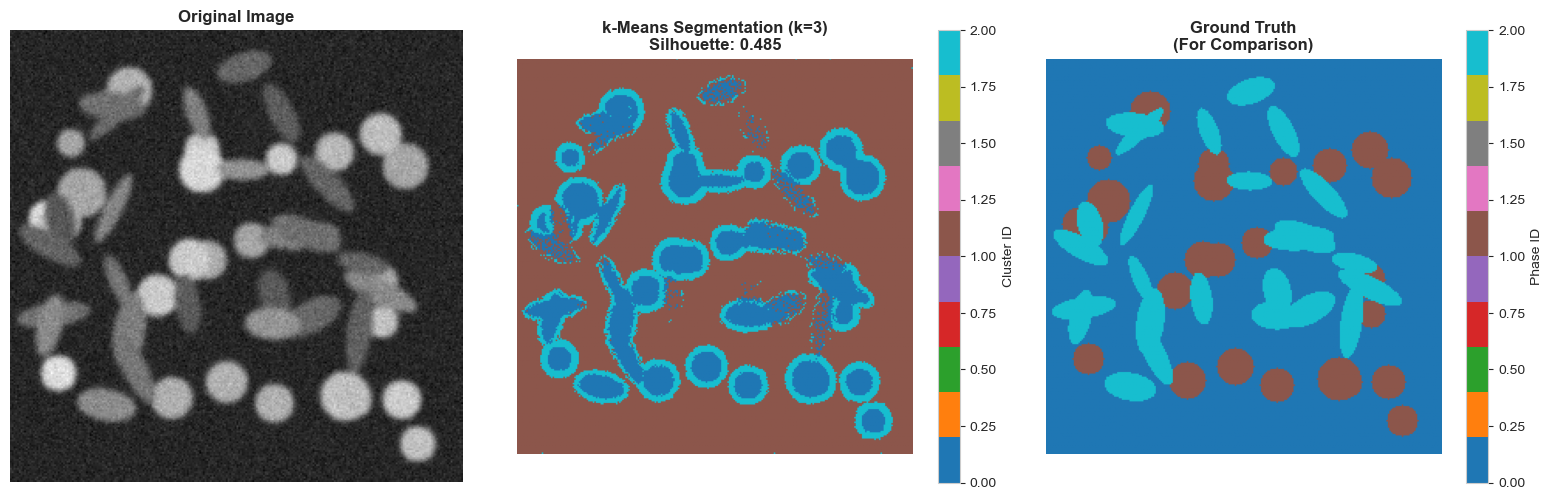

In [7]:
# Apply k-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(features_scaled)

# Reshape to image dimensions
h, w = image.shape
cluster_map = cluster_labels.reshape(h, w)

# Calculate metrics
sil_score = silhouette_score(features_scaled, cluster_labels)
db_score = davies_bouldin_score(features_scaled, cluster_labels)
ch_score = calinski_harabasz_score(features_scaled, cluster_labels)

print(f"\nk-Means Clustering Results (k={optimal_k}):")
print(f"  Silhouette Score: {sil_score:.3f} (higher is better, range [-1, 1])")
print(f"  Davies-Bouldin Index: {db_score:.3f} (lower is better)")
print(f"  Calinski-Harabasz Score: {ch_score:.1f} (higher is better)")
print(f"\nCluster sizes: {np.bincount(cluster_labels)}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

im1 = axes[1].imshow(cluster_map, cmap='tab10')
axes[1].set_title(f'k-Means Segmentation (k={optimal_k})\nSilhouette: {sil_score:.3f}', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], label='Cluster ID')

im2 = axes[2].imshow(true_phase_map, cmap='tab10')
axes[2].set_title('Ground Truth\n(For Comparison)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], label='Phase ID')

plt.tight_layout()
plt.show()

---
## Part 4: DBSCAN (Density-Based Clustering)

DBSCAN groups dense regions and labels sparse points as noise, so it can capture non-spherical grains and flag outliers. Key knobs: `eps` (neighborhood radius) and `min_samples` (points to form a core). We subsample for speed, then map results back to full resolution to visualize clusters vs. noise.

Using 20000 sampled pixels for DBSCAN...

DBSCAN Results:
  Number of clusters: 2
  Number of noise points: 3118 (15.6%)


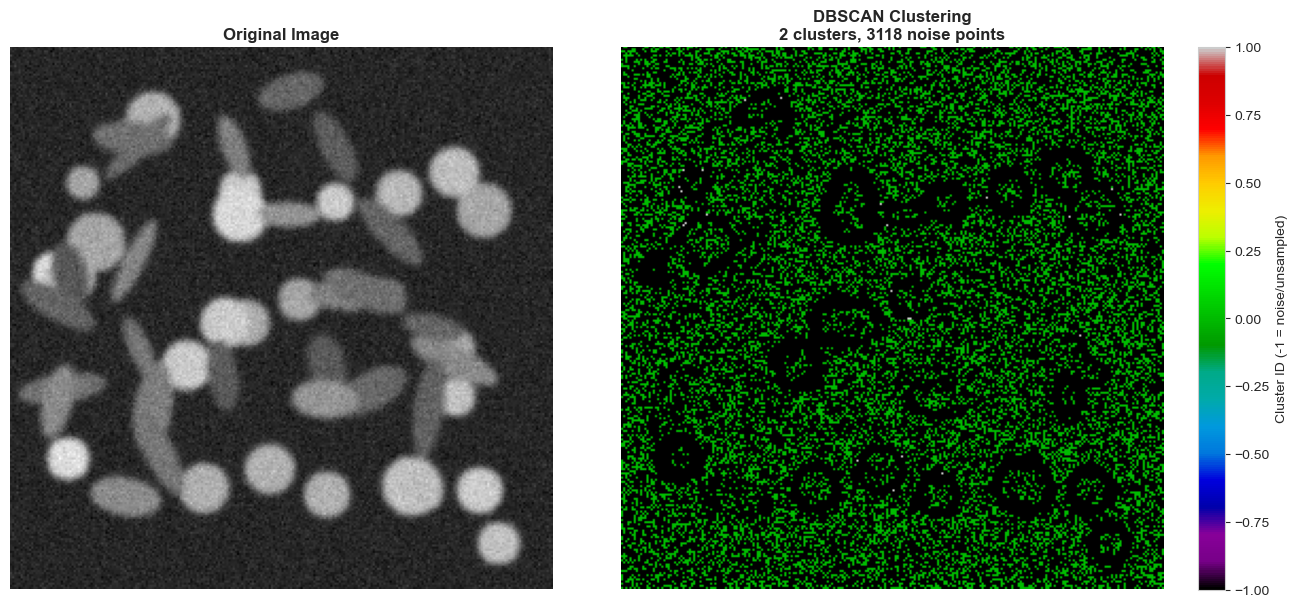

In [8]:
# Subsample for computational efficiency (DBSCAN can be slow)
sample_indices = np.random.choice(len(features_scaled), size=20000, replace=False)
features_sample = features_scaled[sample_indices]
coords_sample = coords[sample_indices]

print(f"Using {len(features_sample)} sampled pixels for DBSCAN...")

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=20, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(features_sample)

# Number of clusters (excluding noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of noise points: {n_noise} ({100*n_noise/len(dbscan_labels):.1f}%)")

# Create full-size map (with -1 for unsampled pixels)
dbscan_map = np.full(image.shape, -1, dtype=int)
dbscan_map[coords_sample[:, 0], coords_sample[:, 1]] = dbscan_labels

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(dbscan_map, cmap='nipy_spectral')
axes[1].set_title(f'DBSCAN Clustering\n{n_clusters_dbscan} clusters, {n_noise} noise points', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], label='Cluster ID (-1 = noise/unsampled)')

plt.tight_layout()
plt.show()

---
## Part 5: Dimensionality Reduction (PCA & t-SNE)

High-dimensional features are hard to inspect directly. PCA gives a linear, variance-maximizing view that preserves global structure and is interpretable (explained variance). t-SNE gives a non-linear, local-neighborhood view that reveals manifold structure. Coloring by clusters or ground truth shows whether phases separate in reduced space.

In [9]:
# PCA: Linear dimensionality reduction
print("Applying PCA...")
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# t-SNE: Non-linear dimensionality reduction (subsample for speed)
print("\nApplying t-SNE (on 10k samples)...")
sample_size = 10000
sample_idx = np.random.choice(len(features_scaled), size=sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_scaled[sample_idx])

print("Dimensionality reduction complete!")

Applying PCA...
Explained variance ratio: [0.51077256 0.24541361]
Total variance explained: 0.756

Applying t-SNE (on 10k samples)...
Dimensionality reduction complete!


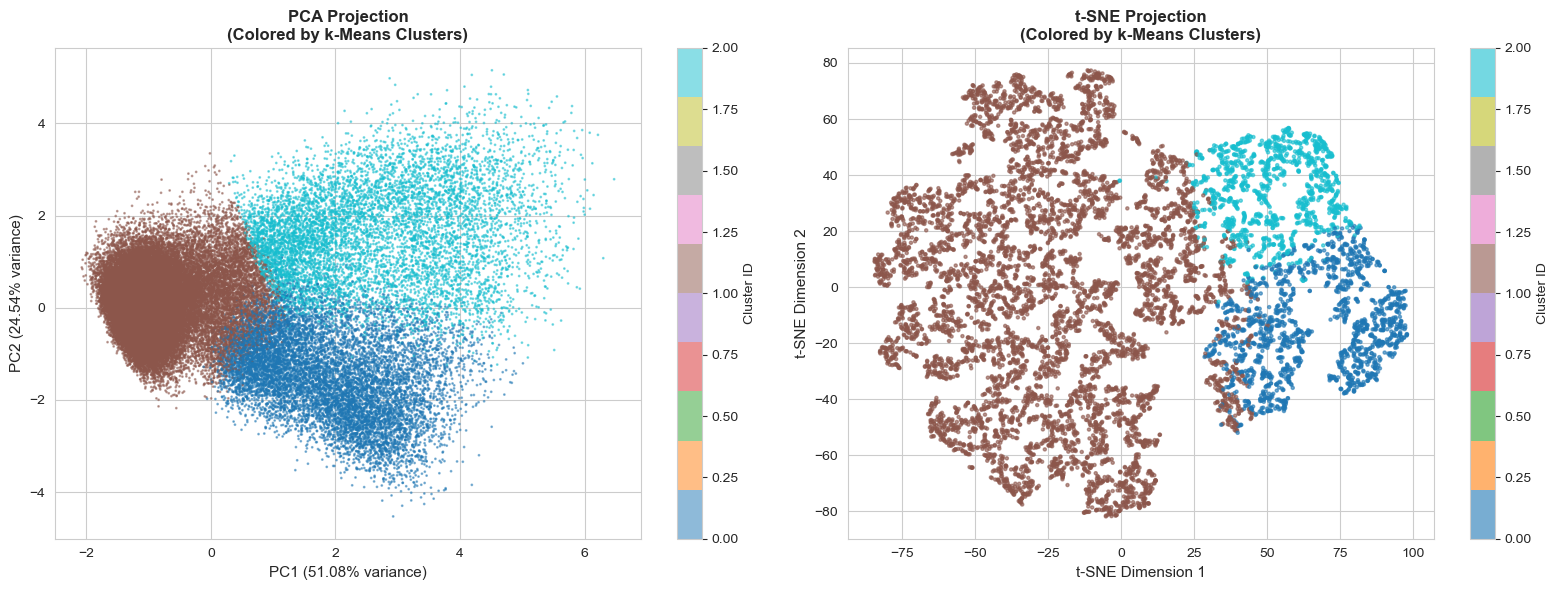

In [10]:
# Visualize PCA and t-SNE colored by k-Means clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
scatter1 = axes[0].scatter(features_pca[:, 0], features_pca[:, 1], 
                           c=cluster_labels, cmap='tab10', s=1, alpha=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
axes[0].set_title('PCA Projection\n(Colored by k-Means Clusters)', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# t-SNE plot
scatter2 = axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], 
                           c=cluster_labels[sample_idx], cmap='tab10', s=5, alpha=0.6)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
axes[1].set_title('t-SNE Projection\n(Colored by k-Means Clusters)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.show()

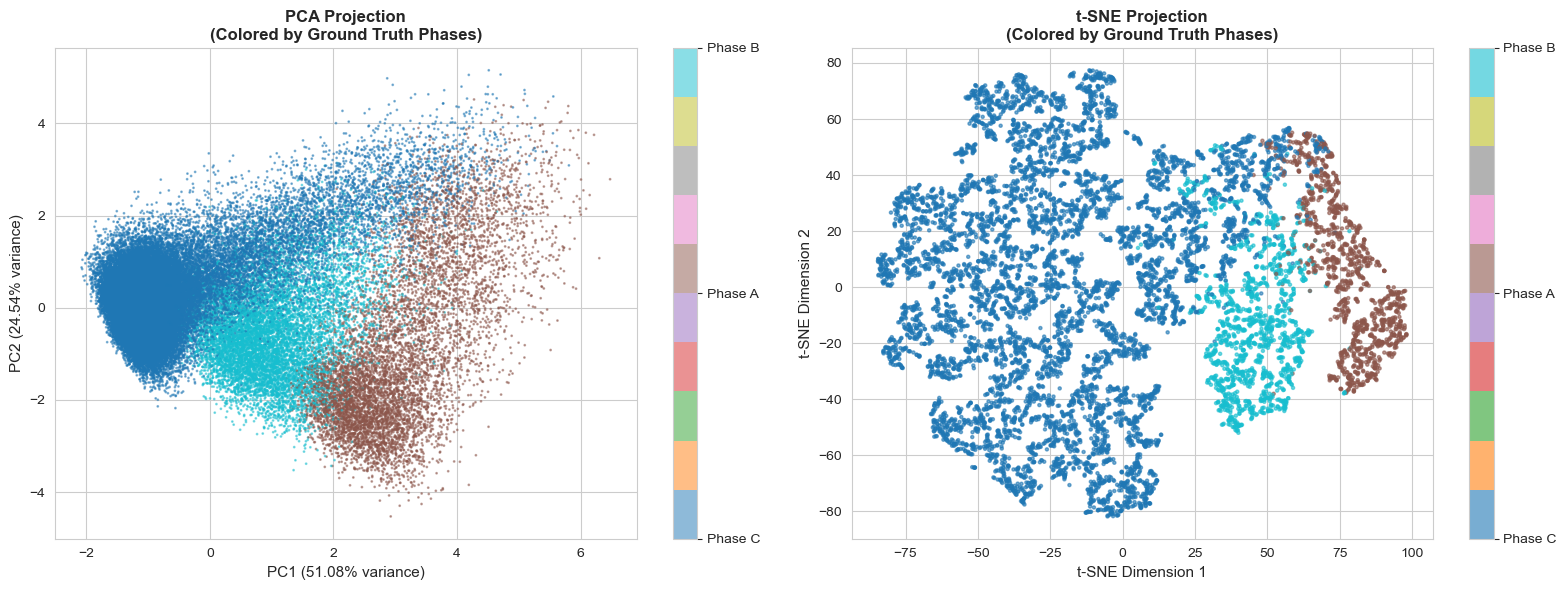

In [11]:
# Visualize by ground truth phases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

true_labels = true_phase_map.ravel()

# PCA colored by true phases
scatter1 = axes[0].scatter(features_pca[:, 0], features_pca[:, 1], 
                           c=true_labels, cmap='tab10', s=1, alpha=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
axes[0].set_title('PCA Projection\n(Colored by Ground Truth Phases)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0], ticks=[0, 1, 2])
cbar1.ax.set_yticklabels(['Phase C', 'Phase A', 'Phase B'])

# t-SNE colored by true phases
scatter2 = axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], 
                           c=true_labels[sample_idx], cmap='tab10', s=5, alpha=0.6)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
axes[1].set_title('t-SNE Projection\n(Colored by Ground Truth Phases)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=[0, 1, 2])
cbar2.ax.set_yticklabels(['Phase C', 'Phase A', 'Phase B'])

plt.tight_layout()
plt.show()

---
## Part 6: Anomaly Detection

Anomalies (defects, contamination) are rare and not represented by clusters. We inject synthetic bright spots, extract the same features, then use Isolation Forest to flag pixels that are easy to isolate in feature space. Precision/recall against the known anomaly mask quantify how sensitive vs. specific the detector is.

In [21]:
# Add synthetic anomalies to the image
def add_anomalies(image, n_anomalies=5):
    """
    Add synthetic defects/anomalies to the image.
    """
    img_with_anomalies = image.copy()
    anomaly_mask = np.zeros(image.shape, dtype=bool)
    
    for _ in range(n_anomalies):
        x = np.random.randint(20, image.shape[1] - 20)
        y = np.random.randint(20, image.shape[0] - 20)
        radius = np.random.randint(3, 8)
        
        # Create bright spot (e.g., contamination)
        Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
        mask = (X - x)**2 + (Y - y)**2 <= radius**2
        
        img_with_anomalies[mask] = np.random.uniform(0.95, 1.0)
        anomaly_mask[mask] = True
    
    return img_with_anomalies, anomaly_mask

# Create image with anomalies
image_with_anomalies, true_anomaly_mask = add_anomalies(image, n_anomalies=8)

# Extract features from anomalous image
features_anom, _ = extract_pixel_features(image_with_anomalies, window_size=7)
features_anom_scaled = scaler.transform(features_anom)

print(f"Added {true_anomaly_mask.sum()} anomalous pixels to the image.")

Added 632 anomalous pixels to the image.


In [22]:
# Apply Isolation Forest for anomaly detection
print("Applying Isolation Forest...")
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
anomaly_predictions = iso_forest.fit_predict(features_anom_scaled)

# -1 = anomaly, 1 = normal
detected_anomalies = (anomaly_predictions == -1)
anomaly_map = detected_anomalies.reshape(image.shape)

n_detected = detected_anomalies.sum()
n_true = true_anomaly_mask.sum()

print(f"\nAnomaly Detection Results:")
print(f"  True anomalies: {n_true}")
print(f"  Detected anomalies: {n_detected}")

# Calculate overlap
true_positives = np.logical_and(true_anomaly_mask, anomaly_map).sum()
precision = true_positives / n_detected if n_detected > 0 else 0
recall = true_positives / n_true if n_true > 0 else 0

print(f"  True positives: {true_positives}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")

Applying Isolation Forest...

Anomaly Detection Results:
  True anomalies: 632
  Detected anomalies: 656
  True positives: 433
  Precision: 0.660
  Recall: 0.685


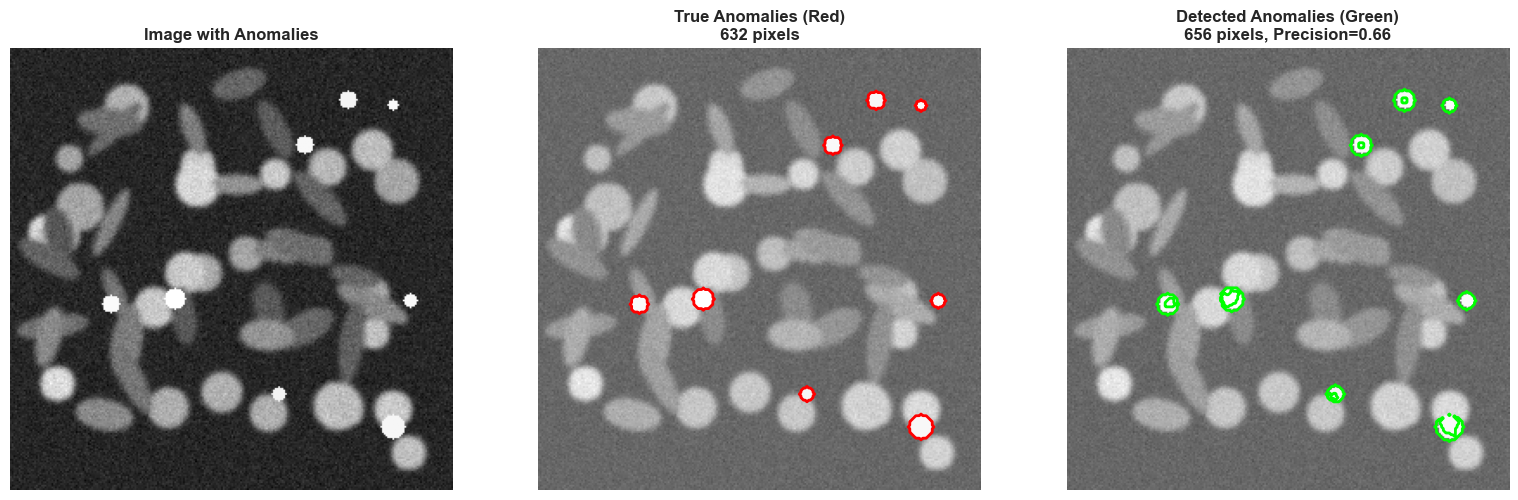

In [23]:
# Visualize anomaly detection results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(image_with_anomalies, cmap='gray')
axes[0].set_title('Image with Anomalies', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_with_anomalies, cmap='gray', alpha=0.7)
axes[1].contour(true_anomaly_mask, colors='red', linewidths=2, levels=[0.5])
axes[1].set_title(f'True Anomalies (Red)\n{n_true} pixels', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(image_with_anomalies, cmap='gray', alpha=0.7)
axes[2].contour(anomaly_map, colors='lime', linewidths=2, levels=[0.5])
axes[2].set_title(f'Detected Anomalies (Green)\n{n_detected} pixels, Precision={precision:.2f}', 
                  fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

---
## Part 7: Non-negative Matrix Factorization (NMF)

For spectrum images (EELS/EDS), signals are additive and non-negative. NMF factorizes the data matrix into non-negative spatial maps and spectral signatures, making components physically interpretable (no negative intensities). We compare recovered maps/signatures to the synthetic ground truth to illustrate spectral unmixing and compositional mapping.

In [24]:
# Create synthetic spectral dataset (simulating EELS or EDS spectrum image)
def create_spectral_image(n_channels=50, img_size=64):
    """
    Simulate a spectrum image with 3 components:
    - Component 1: Peak at channel 10 (e.g., element A)
    - Component 2: Peak at channel 25 (e.g., element B)
    - Component 3: Peak at channel 40 (e.g., element C)
    
    Returns:
        spectrum_image: (img_size, img_size, n_channels)
        component_maps: Ground truth spatial distributions
    """
    # Create spectral signatures
    channels = np.arange(n_channels)
    
    spec1 = np.exp(-((channels - 10)**2) / (2 * 3**2))  # Gaussian peak at ch 10
    spec2 = np.exp(-((channels - 25)**2) / (2 * 4**2))  # Gaussian peak at ch 25
    spec3 = np.exp(-((channels - 40)**2) / (2 * 3**2))  # Gaussian peak at ch 40
    
    # Create spatial distributions
    Y, X = np.meshgrid(np.linspace(-1, 1, img_size), np.linspace(-1, 1, img_size), indexing='ij')
    
    map1 = np.exp(-(X**2 + Y**2) / 0.5)  # Center
    map2 = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2) / 0.3)  # Top-right
    map3 = np.exp(-((X + 0.5)**2 + (Y + 0.5)**2) / 0.3)  # Bottom-left
    
    # Combine
    spectrum_image = np.zeros((img_size, img_size, n_channels))
    for i in range(img_size):
        for j in range(img_size):
            spectrum_image[i, j, :] = (map1[i, j] * spec1 + 
                                       map2[i, j] * spec2 + 
                                       map3[i, j] * spec3)
    
    # Add noise
    spectrum_image += np.random.normal(0, 0.05, spectrum_image.shape)
    spectrum_image = np.maximum(spectrum_image, 0)  # Non-negative
    
    component_maps = np.stack([map1, map2, map3], axis=-1)
    
    return spectrum_image, component_maps, np.stack([spec1, spec2, spec3])

# Generate synthetic spectral data
spectrum_image, true_maps, true_spectra = create_spectral_image(n_channels=50, img_size=64)
print(f"Spectrum image shape: {spectrum_image.shape}")
print(f"Shape: {spectrum_image.shape[0]}×{spectrum_image.shape[1]} pixels, {spectrum_image.shape[2]} channels")

Spectrum image shape: (64, 64, 50)
Shape: 64×64 pixels, 50 channels


In [16]:
# Reshape for NMF: (n_pixels, n_channels)
h, w, n_ch = spectrum_image.shape
spectra_matrix = spectrum_image.reshape(-1, n_ch)

# Apply NMF
print("Applying NMF decomposition...")
n_components = 3
nmf = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=500)
spatial_components = nmf.fit_transform(spectra_matrix)  # (n_pixels, n_components)
spectral_components = nmf.components_  # (n_components, n_channels)

# Reshape spatial components back to image
component_maps_nmf = spatial_components.reshape(h, w, n_components)

print(f"\nNMF reconstruction error: {nmf.reconstruction_err_:.3f}")
print(f"Component maps shape: {component_maps_nmf.shape}")
print(f"Spectral signatures shape: {spectral_components.shape}")

Applying NMF decomposition...

NMF reconstruction error: 18.041
Component maps shape: (64, 64, 3)
Spectral signatures shape: (3, 50)


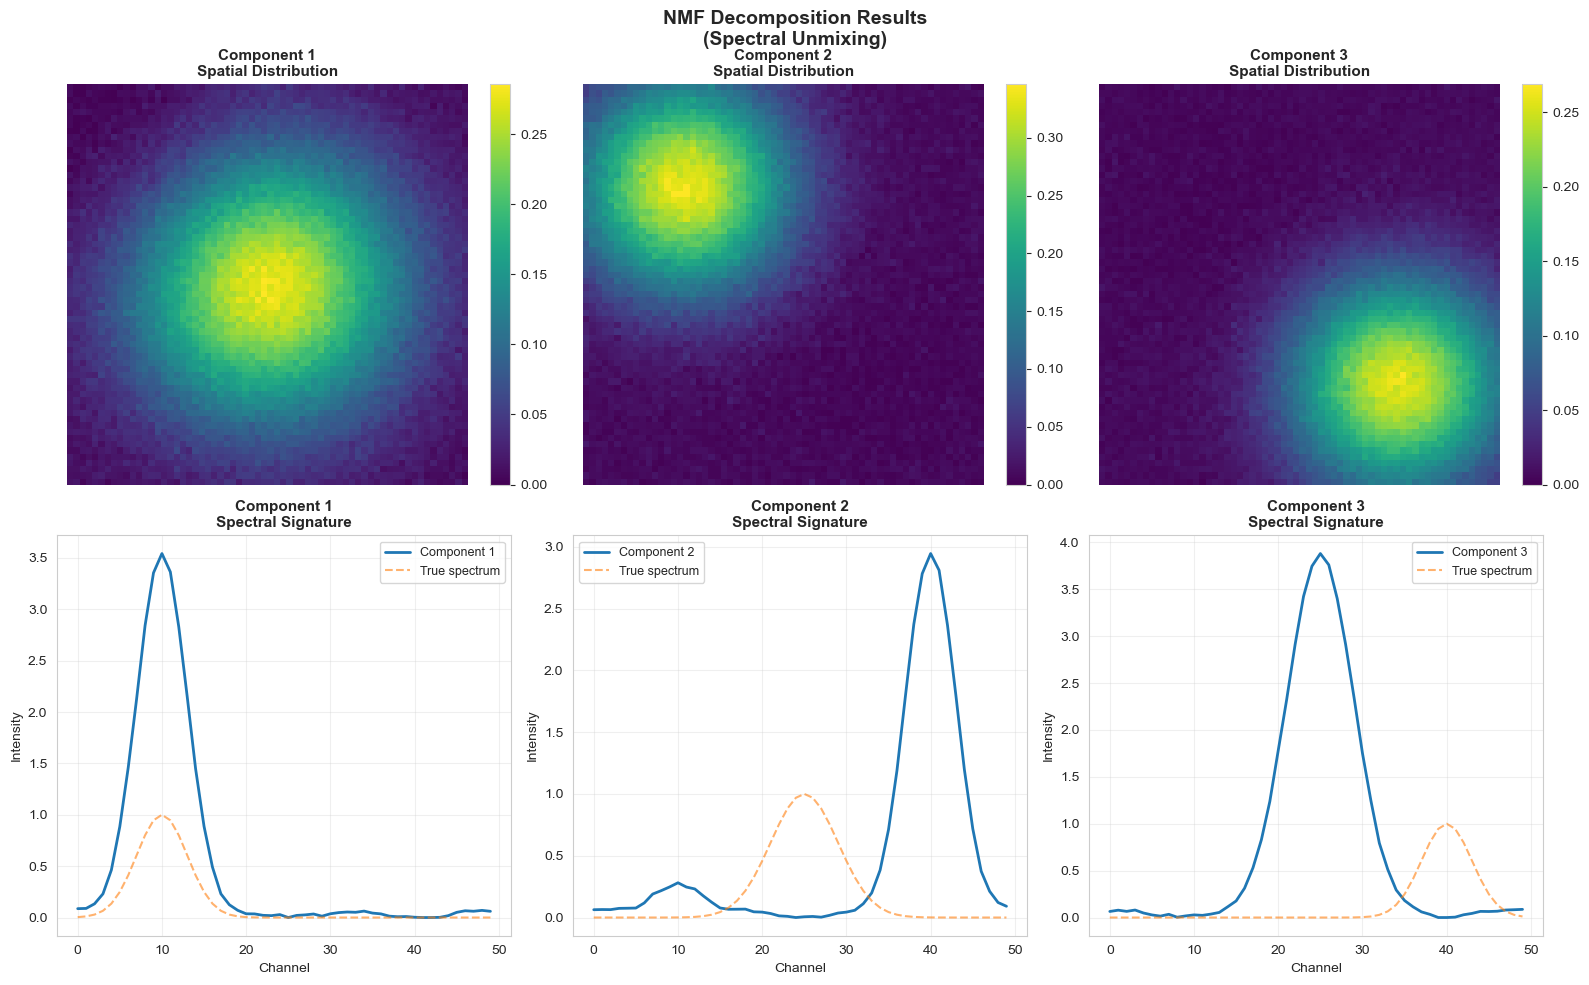

In [17]:
# Visualize NMF results
fig = plt.figure(figsize=(16, 10))

# Top row: Spatial component maps
for i in range(n_components):
    ax = plt.subplot(2, n_components, i + 1)
    im = ax.imshow(component_maps_nmf[:, :, i], cmap='viridis')
    ax.set_title(f'Component {i+1}\nSpatial Distribution', fontsize=11, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Bottom row: Spectral signatures
for i in range(n_components):
    ax = plt.subplot(2, n_components, n_components + i + 1)
    ax.plot(spectral_components[i], linewidth=2, label=f'Component {i+1}')
    ax.plot(true_spectra[i], '--', alpha=0.6, label='True spectrum')
    ax.set_xlabel('Channel', fontsize=10)
    ax.set_ylabel('Intensity', fontsize=10)
    ax.set_title(f'Component {i+1}\nSpectral Signature', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('NMF Decomposition Results\n(Spectral Unmixing)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

---
## Summary and Key Takeaways

### What We Learned:

1. **Clustering Algorithms**:
   - **k-Means**: Fast, requires specifying k, assumes spherical clusters
   - **DBSCAN**: Finds arbitrary shapes, identifies noise, no need to specify k
   - **Evaluation**: Silhouette score, Davies-Bouldin index, Calinski-Harabasz score

2. **Dimensionality Reduction**:
   - **PCA**: Linear, preserves global structure, interpretable components
   - **t-SNE**: Non-linear, preserves local structure, better for visualization
   - **Use cases**: Exploratory analysis, feature visualization, data compression

3. **Anomaly Detection**:
   - **Isolation Forest**: Efficient for high-dimensional data
   - **Applications**: Defect detection, contamination identification, rare event discovery
   - **Tuning**: Contamination parameter controls sensitivity

4. **Matrix Factorization (NMF)**:
   - **Non-negativity constraint**: Natural for spectroscopic data (intensities ≥ 0)
   - **Interpretability**: Components represent physical constituents
   - **Applications**: EELS/EDS unmixing, compositional mapping

### Best Practices for Microscopy:

- **Feature engineering is critical**: Domain knowledge guides feature selection
- **Standardize features**: Essential for distance-based methods
- **Validate qualitatively**: Visual inspection complements quantitative metrics
- **Consider computational cost**: Subsample large datasets (millions of pixels)
- **Combine methods**: Use PCA before clustering to reduce dimensionality
- **Domain constraints**: NMF's non-negativity is physically meaningful for spectra

### When to Use Unsupervised Learning:

✅ **Good for:**
- Exploratory data analysis
- Discovering unknown phases/structures
- Large unlabeled datasets
- Reducing labeling burden
- Spectral unmixing and decomposition

❌ **Not ideal for:**
- Well-defined classification tasks (use supervised learning)
- When labeled data is abundant
- Precise quantitative measurements (without validation)

### Next Steps:
- Combine unsupervised (clustering) + supervised (classification) in semi-supervised workflows
- Apply to real EM datasets (STEM, 4D-STEM, EELS spectrum images)
- Explore deep unsupervised methods (autoencoders, variational autoencoders)
- Use clustering for intelligent data labeling (active learning)